In [1]:
import numpy as np
import sqlite3
import plotly.express as px
import pandas as pd
import sqlite3
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import statsmodels
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from useful_functions_2 import *
from pdf2image import convert_from_path
from sklearn.manifold import TSNE
from scipy.spatial.distance import braycurtis
from skbio.stats.distance import permanova
from scipy.spatial.distance import pdist
from skbio.stats.distance import DistanceMatrix

### Define Parameters

In [2]:
standard_scale = False
sum_to_one = False
number_taxa_included = 1000

### Import Data

In [3]:
tables_to_join = ["tPlantMicrobeGenus", "tSample", "tPlantDNA"]
common_column = "sample_id"
full_df = import_all_data(tables_to_join, common_column)
print(full_df.shape)
full_df = full_df.T.drop_duplicates().T

(43811, 15)


In [4]:
full_df.shape

(43811, 13)

### Make DF Copies

In [5]:
df = full_df.copy()
subdf = df.copy()

### Organize Data

In [6]:
subdf.head()

,sample_id,genera,relative_abundance,site_id,collect_date,V1,V2,species,PC1,PC2,PC3,PC4,PC5
0,RRL1,Bacteria|Actinobacteria|Actinobacteria|Coryneb...,0.63776,RRL,6/25/2021,0.753244,0.246756,exaltata,0.194769,0.048276,-0.02388,-0.017138,-0.039842
1,RRL1,Bacteria|Proteobacteria|Alphaproteobacteria|Rh...,0.11405,RRL,6/25/2021,0.753244,0.246756,exaltata,0.194769,0.048276,-0.02388,-0.017138,-0.039842
2,RRL1,Bacteria|Proteobacteria|Gammaproteobacteria|Ps...,0.1119,RRL,6/25/2021,0.753244,0.246756,exaltata,0.194769,0.048276,-0.02388,-0.017138,-0.039842
3,RRL1,Bacteria|Bacteroidetes|Cytophagia|Cytophagales...,0.09485,RRL,6/25/2021,0.753244,0.246756,exaltata,0.194769,0.048276,-0.02388,-0.017138,-0.039842
4,RRL1,Bacteria|Proteobacteria|Alphaproteobacteria|Sp...,0.08559,RRL,6/25/2021,0.753244,0.246756,exaltata,0.194769,0.048276,-0.02388,-0.017138,-0.039842


In [7]:
origin_pivoted_df = subdf.pivot(index=['sample_id', 'site_id', 'species', 'V2'], columns='genera', values='relative_abundance')
origin_pivoted_df.shape
origin_pivoted_df.columns.name = None

### Sum Microbe Data to One

In [8]:
if sum_to_one == True:
    
    row_sum = origin_pivoted_df.sum(axis=1)

    origin_pivoted_df = origin_pivoted_df.reset_index()

    genera_col = origin_pivoted_df.columns
    genera_col = genera_col.drop(['sample_id','site_id', 'species', 'V2'])

    sub_pivot = origin_pivoted_df[genera_col].astype(float)

    for row in range(sub_pivot.shape[0]):
        sub_pivot.loc[row] = sub_pivot.loc[row]/row_sum[row]

    new_sum = sub_pivot.sum(axis=1)
    new_sum

    origin_pivoted_df[genera_col] = sub_pivot

    origin_pivoted_df.head()

    row_sum = origin_pivoted_df[genera_col].sum(axis=1)
else:
    origin_pivoted_df = origin_pivoted_df.reset_index()
    genera_col = origin_pivoted_df.columns
    genera_col = genera_col.drop(['sample_id','site_id', 'species', 'V2'])

In [9]:
origin_pivoted_df = origin_pivoted_df.reset_index()

In [10]:
origin_pivoted_df[genera_col] = origin_pivoted_df[genera_col].astype(float)
sum_row = origin_pivoted_df[genera_col].sum()

### Reduce Data to Most Abundant Taxa

In [11]:
sum_row = origin_pivoted_df[genera_col].sum()

abundant_genera = sum_row.nlargest(number_taxa_included)

select_columns = (abundant_genera.index).tolist()
select_columns.insert(0, 'V2')
select_columns.insert(0, 'sample_id')
select_columns.insert(0, 'site_id')
select_columns.insert(0, 'species')

origin_pivoted_df = origin_pivoted_df[select_columns]

origin_pivoted_df.head()

,species,site_id,sample_id,V2,Bacteria|Proteobacteria|Gammaproteobacteria|Pseudomonadales|Pseudomonadaceae|Pseudomonas,Bacteria|Proteobacteria|Alphaproteobacteria|Sphingomonadales|Sphingomonadaceae|Sphingomonas,Bacteria|Actinobacteria|Actinobacteria|Corynebacteriales|Corynebacteriaceae|Corynebacterium,Bacteria|Bacteroidetes|Chitinophagia|Chitinophagales|Chitinophagaceae|Asinibacterium,Bacteria|Firmicutes|Clostridia|Clostridiales|Clostridiaceae|Clostridium,Bacteria|Proteobacteria|Alphaproteobacteria|Rhizobiales|Bradyrhizobiaceae|Bradyrhizobium,...,Bacteria|Proteobacteria|Alphaproteobacteria|Rhodospirillales|Acetobacteraceae|Acidocella,Eukaryota|Ascomycota|Dothideomycetes|Myriangiales|Elsinoaceae|Sphaceloma,Bacteria|Armatimonadetes|Fimbriimonadia|Fimbriimonadales|Fimbriimonadaceae|Fimbriimonas,Bacteria|Deinococcus-Thermus|Deinococci|Thermales|Thermaceae|Meiothermus,Bacteria|Proteobacteria|Gammaproteobacteria|Enterobacterales|Enterobacteriaceae|Siccibacter,Bacteria|Firmicutes|Bacilli|Bacillales|Paenibacillaceae|Saccharibacillus,Bacteria|Proteobacteria|Gammaproteobacteria|Aeromonadales|Aeromonadaceae|Oceanisphaera,Eukaryota|Ascomycota|Eurotiomycetes|Onygenales|Ajellomycetaceae|Histoplasma,Bacteria|Firmicutes|Clostridia|Clostridiales|Lachnospiraceae|Shuttleworthia,Bacteria|Proteobacteria|Alphaproteobacteria|Rhodospirillales|Rhodospirillaceae|Dongia
0,syriaca,CMB,CMB10,0.999777,0.71969,4.65386,0.00752,0.41737,0.85953,0.62364,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00013,NaN,NaN
1,syriaca,CMB,CMB11,1.000000,2.64833,1.26191,0.01694,0.35352,0.01393,0.38655,...,NaN,NaN,NaN,NaN,0.00013,NaN,NaN,NaN,NaN,NaN
2,syriaca,CMB,CMB13,0.989131,2.85174,1.66552,0.01089,0.22626,0.77440,0.31579,...,NaN,0.00011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,syriaca,CMB,CMB14,0.999992,0.82043,0.83340,0.00533,0.07512,0.01104,0.07820,...,NaN,0.00012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,syriaca,CMB,CMB15,0.998548,13.04768,1.69613,0.00593,0.06380,0.17548,0.05448,...,NaN,NaN,NaN,NaN,0.00043,NaN,NaN,NaN,NaN,NaN


In [12]:
opdf = origin_pivoted_df.copy()
opdf = opdf.fillna(0)
microbe_cols = opdf.columns.drop(['species', 'site_id', 'sample_id', 'V2'])

### Apply Standard Scaler to Data

In [13]:
if standard_scale:
    print('HERE')
    opdf[microbe_cols] = StandardScaler().fit_transform(opdf[microbe_cols])  

### Subset Data to Syriaca, Exaltata

In [14]:
opdf = opdf[opdf["species"].isin(['syriaca','exaltata'])]


In [15]:
df = opdf
site_list = df['site_id']

df['BGR'] = site_list

df['BGR'].replace({'CMB': 1, 'FRW': 1, 'LFS': 1, 'LM': 0, 'MMP': 1, 'MKP': 2,
                    'PNR': 2, 'PTW': 0, 'RF': 2, 'RGT': 0, 'RRL': 0, 'SGC': 0, 'SLG': 1,'HR': 3}, inplace=True) #
df = df[df["BGR"].isin([0,1,2,3])]

df['BGR'] = df['BGR'].replace([0], 'Wintergreen')
df['BGR'] = df['BGR'].replace([1], 'Cole Mountain')
df['BGR'] = df['BGR'].replace([2], 'Blacksburg')
df['BGR'] = df['BGR'].replace([3], 'HR')

site_list = ['RRL', 'FRW', 'MMP', 'PNR', 'CMB', 'SLG', 'RF', 'LFS', 'PTW', 'LM', 'MKP', 'RGT']

# Predefined set of colors
unique_colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'pink', 'brown', 'gray', 'olive', 'lime', 'teal']

# Create a dictionary with list elements as keys and corresponding colors as values
site_color_dict = dict(zip(site_list, unique_colors))

print(site_color_dict)

{'RRL': 'red', 'FRW': 'green', 'MMP': 'blue', 'PNR': 'orange', 'CMB': 'purple', 'SLG': 'cyan', 'RF': 'pink', 'LFS': 'brown', 'PTW': 'gray', 'LM': 'olive', 'MKP': 'lime', 'RGT': 'teal'}


### Remove Outliers

In [16]:
df = df.reset_index(drop=True)
df.head(50)

,species,site_id,sample_id,V2,Bacteria|Proteobacteria|Gammaproteobacteria|Pseudomonadales|Pseudomonadaceae|Pseudomonas,Bacteria|Proteobacteria|Alphaproteobacteria|Sphingomonadales|Sphingomonadaceae|Sphingomonas,Bacteria|Actinobacteria|Actinobacteria|Corynebacteriales|Corynebacteriaceae|Corynebacterium,Bacteria|Bacteroidetes|Chitinophagia|Chitinophagales|Chitinophagaceae|Asinibacterium,Bacteria|Firmicutes|Clostridia|Clostridiales|Clostridiaceae|Clostridium,Bacteria|Proteobacteria|Alphaproteobacteria|Rhizobiales|Bradyrhizobiaceae|Bradyrhizobium,...,Eukaryota|Ascomycota|Dothideomycetes|Myriangiales|Elsinoaceae|Sphaceloma,Bacteria|Armatimonadetes|Fimbriimonadia|Fimbriimonadales|Fimbriimonadaceae|Fimbriimonas,Bacteria|Deinococcus-Thermus|Deinococci|Thermales|Thermaceae|Meiothermus,Bacteria|Proteobacteria|Gammaproteobacteria|Enterobacterales|Enterobacteriaceae|Siccibacter,Bacteria|Firmicutes|Bacilli|Bacillales|Paenibacillaceae|Saccharibacillus,Bacteria|Proteobacteria|Gammaproteobacteria|Aeromonadales|Aeromonadaceae|Oceanisphaera,Eukaryota|Ascomycota|Eurotiomycetes|Onygenales|Ajellomycetaceae|Histoplasma,Bacteria|Firmicutes|Clostridia|Clostridiales|Lachnospiraceae|Shuttleworthia,Bacteria|Proteobacteria|Alphaproteobacteria|Rhodospirillales|Rhodospirillaceae|Dongia,BGR
0,syriaca,CMB,CMB10,0.999777,0.71969,4.65386,0.00752,0.41737,0.85953,0.62364,...,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.00013,0.00000,0.00000,Cole Mountain
1,syriaca,CMB,CMB11,1.000000,2.64833,1.26191,0.01694,0.35352,0.01393,0.38655,...,0.00000,0.0,0.00000,0.00013,0.0,0.0,0.00000,0.00000,0.00000,Cole Mountain
2,syriaca,CMB,CMB13,0.989131,2.85174,1.66552,0.01089,0.22626,0.77440,0.31579,...,0.00011,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,Cole Mountain
3,syriaca,CMB,CMB14,0.999992,0.82043,0.83340,0.00533,0.07512,0.01104,0.07820,...,0.00012,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,Cole Mountain
4,syriaca,CMB,CMB15,0.998548,13.04768,1.69613,0.00593,0.06380,0.17548,0.05448,...,0.00000,0.0,0.00000,0.00043,0.0,0.0,0.00000,0.00000,0.00000,Cole Mountain
5,syriaca,CMB,CMB16,0.999243,0.71368,6.04290,0.02018,0.28476,0.02373,0.34684,...,0.00012,0.0,0.00000,0.00000,0.0,0.0,0.00049,0.00000,0.00000,Cole Mountain
6,syriaca,CMB,CMB17,1.000000,17.46418,0.88809,0.00733,0.10878,0.34812,0.10073,...,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,Cole Mountain
7,syriaca,CMB,CMB18,1.000000,4.45930,0.89351,0.00083,0.15144,0.00899,0.24032,...,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.00014,0.00000,0.00000,Cole Mountain
8,syriaca,CMB,CMB19,0.999935,6.62369,1.35329,0.01266,0.18926,0.40398,0.17533,...,0.00000,0.0,0.00000,0.00013,0.0,0.0,0.00000,0.00000,0.00000,Cole Mountain
9,syriaca,CMB,CMB20,0.994411,14.34852,1.23421,0.00587,0.01629,0.17228,0.05608,...,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,Cole Mountain


In [17]:
# X = df[microbe_cols]

# pca = PCA(n_components=2)
# principal_components = pca.fit_transform(X)

# pc1 = []
# pc2 = []
# for i in principal_components:
#     pc1.append(i[0])
#     pc2.append(i[1])
    
# pc1_q3, pc1_q1 = np.percentile(pc1, [75 ,25])
# iqr1 = pc1_q3 - pc1_q1
# pc2_q3, pc2_q1 = np.percentile(pc2, [75 ,25])
# iqr2 = pc2_q3 - pc2_q1

# print(pc1_q3 + iqr1)
# print(pc2_q3 + iqr2)

# drop_index = 0
# for i in enumerate(principal_components):
#     if i[1][0] > pc1_q3 + iqr1 *1.5:
#         print(i)
#         drop_index = (i[0])
#         df = df.drop(index=drop_index)
#     elif i[1][1] > pc2_q3 + iqr2 * 1.5:
#         print(i)
#         #print(i)
#         drop_index = (i[0])
#         df = df.drop(index=drop_index)
#     #print(df.shape)
    
    
        
# # df = df.reset_index()         
# df = df.drop(index=drop_indexs)

In [18]:
df.head(50)

,species,site_id,sample_id,V2,Bacteria|Proteobacteria|Gammaproteobacteria|Pseudomonadales|Pseudomonadaceae|Pseudomonas,Bacteria|Proteobacteria|Alphaproteobacteria|Sphingomonadales|Sphingomonadaceae|Sphingomonas,Bacteria|Actinobacteria|Actinobacteria|Corynebacteriales|Corynebacteriaceae|Corynebacterium,Bacteria|Bacteroidetes|Chitinophagia|Chitinophagales|Chitinophagaceae|Asinibacterium,Bacteria|Firmicutes|Clostridia|Clostridiales|Clostridiaceae|Clostridium,Bacteria|Proteobacteria|Alphaproteobacteria|Rhizobiales|Bradyrhizobiaceae|Bradyrhizobium,...,Eukaryota|Ascomycota|Dothideomycetes|Myriangiales|Elsinoaceae|Sphaceloma,Bacteria|Armatimonadetes|Fimbriimonadia|Fimbriimonadales|Fimbriimonadaceae|Fimbriimonas,Bacteria|Deinococcus-Thermus|Deinococci|Thermales|Thermaceae|Meiothermus,Bacteria|Proteobacteria|Gammaproteobacteria|Enterobacterales|Enterobacteriaceae|Siccibacter,Bacteria|Firmicutes|Bacilli|Bacillales|Paenibacillaceae|Saccharibacillus,Bacteria|Proteobacteria|Gammaproteobacteria|Aeromonadales|Aeromonadaceae|Oceanisphaera,Eukaryota|Ascomycota|Eurotiomycetes|Onygenales|Ajellomycetaceae|Histoplasma,Bacteria|Firmicutes|Clostridia|Clostridiales|Lachnospiraceae|Shuttleworthia,Bacteria|Proteobacteria|Alphaproteobacteria|Rhodospirillales|Rhodospirillaceae|Dongia,BGR
0,syriaca,CMB,CMB10,0.999777,0.71969,4.65386,0.00752,0.41737,0.85953,0.62364,...,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.00013,0.00000,0.00000,Cole Mountain
1,syriaca,CMB,CMB11,1.000000,2.64833,1.26191,0.01694,0.35352,0.01393,0.38655,...,0.00000,0.0,0.00000,0.00013,0.0,0.0,0.00000,0.00000,0.00000,Cole Mountain
2,syriaca,CMB,CMB13,0.989131,2.85174,1.66552,0.01089,0.22626,0.77440,0.31579,...,0.00011,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,Cole Mountain
3,syriaca,CMB,CMB14,0.999992,0.82043,0.83340,0.00533,0.07512,0.01104,0.07820,...,0.00012,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,Cole Mountain
4,syriaca,CMB,CMB15,0.998548,13.04768,1.69613,0.00593,0.06380,0.17548,0.05448,...,0.00000,0.0,0.00000,0.00043,0.0,0.0,0.00000,0.00000,0.00000,Cole Mountain
5,syriaca,CMB,CMB16,0.999243,0.71368,6.04290,0.02018,0.28476,0.02373,0.34684,...,0.00012,0.0,0.00000,0.00000,0.0,0.0,0.00049,0.00000,0.00000,Cole Mountain
6,syriaca,CMB,CMB17,1.000000,17.46418,0.88809,0.00733,0.10878,0.34812,0.10073,...,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,Cole Mountain
7,syriaca,CMB,CMB18,1.000000,4.45930,0.89351,0.00083,0.15144,0.00899,0.24032,...,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.00014,0.00000,0.00000,Cole Mountain
8,syriaca,CMB,CMB19,0.999935,6.62369,1.35329,0.01266,0.18926,0.40398,0.17533,...,0.00000,0.0,0.00000,0.00013,0.0,0.0,0.00000,0.00000,0.00000,Cole Mountain
9,syriaca,CMB,CMB20,0.994411,14.34852,1.23421,0.00587,0.01629,0.17228,0.05608,...,0.00000,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,Cole Mountain


In [19]:
site_list = df['site_id']

df['run_id'] = site_list

df['run_id'].replace({'RRL': 1, 'FRW': 1, 'MMP': 1, 'PNR': 1, 'CMB': 1, 'SLG': 1,
                    'SGC': 2, 'LFS': 2, 'RF': 2, 'RGT': 2, 'LM': 2, 'PTW': 2, 'MKP': 2,'HR': 2, 'GH': 2}, inplace=True) #

df = df[df["run_id"].isin([1, 2])]
df.shape

(156, 1006)

In [20]:
df.shape

(156, 1006)

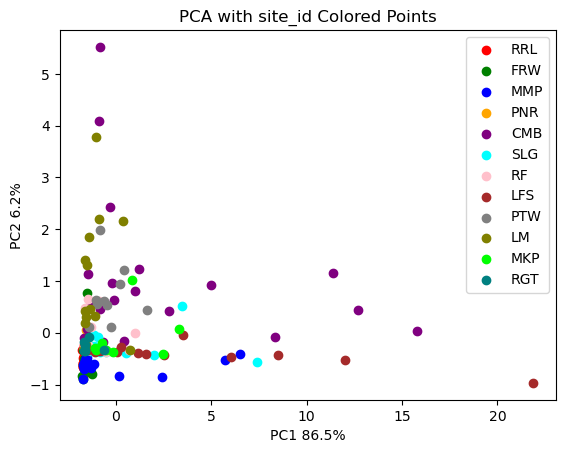

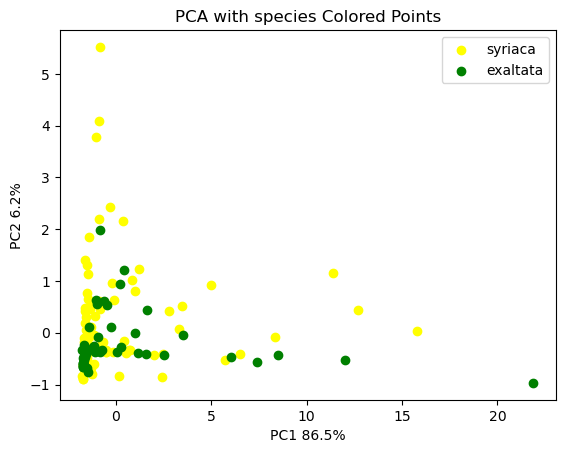

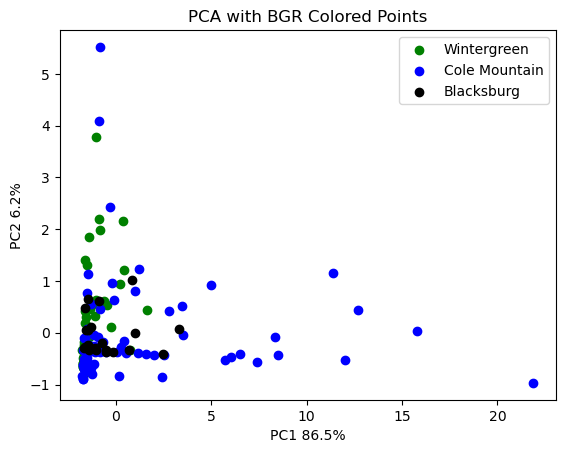

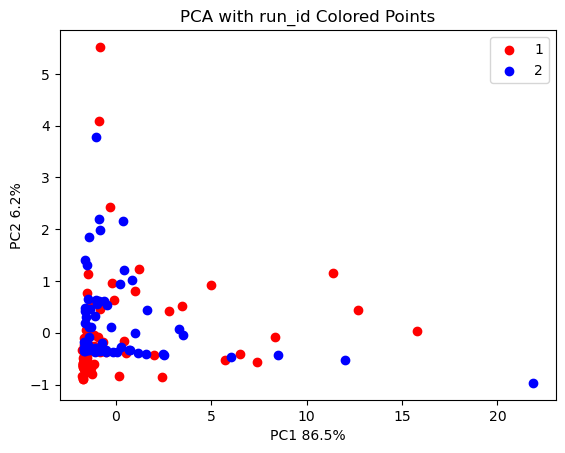

In [21]:
X = df[microbe_cols]

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

for graph_type in ['site_id', 'species', 'BGR', 'run_id']:
    if graph_type == 'site_id':
        colors = site_color_dict
    elif graph_type == 'species':
        colors = {'syriaca': 'yellow', 'exaltata': 'green'}
    elif graph_type == 'BGR':
        colors = {'Wintergreen': 'green', 'Cole Mountain': 'blue', 'Blacksburg': 'black'}
    else:
        colors = {1: 'red', 2: 'blue'}
    
    fig, ax = plt.subplots()

    for key, color in colors.items():
        mask = (df[graph_type] == key)
        ax.scatter(
            principal_components[mask, 0],
            principal_components[mask, 1],
            c=color,
            label= key
        )
    
    ax.set_xlabel("PC1 " + str(round(100*pca.explained_variance_ratio_[0], 1)) + '%')
    ax.set_ylabel("PC2 " + str(round(100*pca.explained_variance_ratio_[1], 1)) + '%')
    ax.set_title('PCA with ' + graph_type + ' Colored Points')
    ax.legend()
    plt.show()
    if graph_type == 'site_id':
        ax.set_title('PCA of Field Sites and Leaf Microbiome')
        fig1 = fig
    elif graph_type == 'species':
        ax.set_title('PCA of Plant Species and Leaf Microbiome')
        fig2 = fig
    elif graph_type == 'BGR':
        ax.set_title('PCA of Broad Geographic Region and Leaf Microbiome')
        fig3 = fig
    else:
        ax.set_title('PCA of Run Id and Leaf Microbiome')
        fig3 = fig

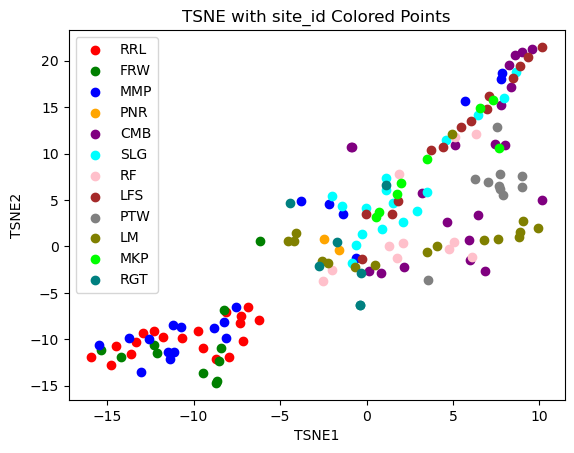

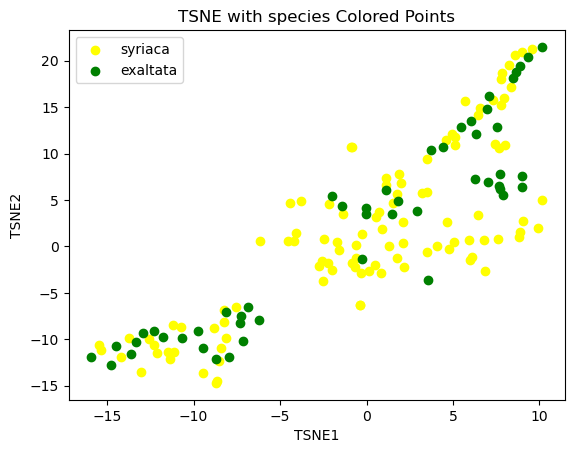

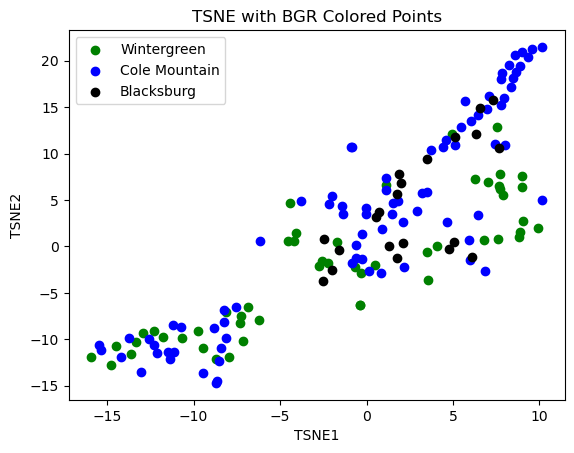

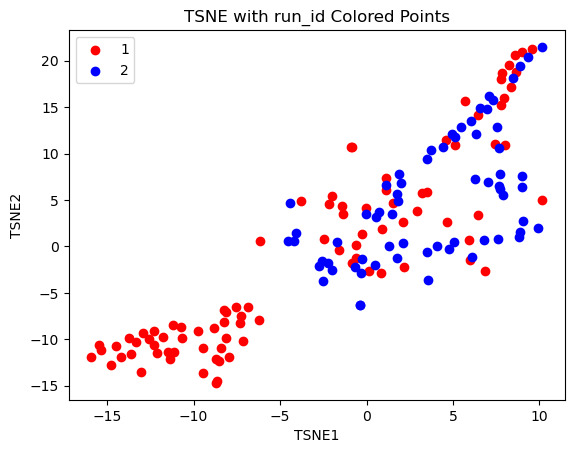

In [22]:
perplexity_value = 20 # Change this to your desired perplexity

tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=126)
tsne_transformed = tsne.fit_transform(df[microbe_cols])


for graph_type in ['site_id', 'species', 'BGR', 'run_id']:
    if graph_type == 'site_id':
        colors = site_color_dict
    elif graph_type == 'species':
        colors = {'syriaca': 'yellow', 'exaltata': 'green'}
    elif graph_type == 'BGR':
        colors = {'Wintergreen': 'green', 'Cole Mountain': 'blue', 'Blacksburg': 'black'}
    else:
        colors = {1: 'red', 2: 'blue'}
    fig, ax = plt.subplots()

    for key, color in colors.items():
        mask = (df[graph_type] == key)
        ax.scatter(
            tsne_transformed[mask, 0],
            tsne_transformed[mask, 1],
            c=color,
            label= key
        )
    
    ax.set_xlabel("TSNE1")
    ax.set_ylabel("TSNE2")
    ax.set_title('TSNE with ' + graph_type + ' Colored Points')
    ax.legend()
    plt.show()

    if graph_type == 'site_id':
        ax.set_title('TSNE of Field Site and Leaf Microbiome, P.V. = ' + str(perplexity_value))
        fig4 = fig
    elif graph_type == 'species':
        ax.set_title('TSNE of Species and Leaf Microbiome, P.V. = ' + str(perplexity_value))
        fig5 = fig
    elif graph_type == 'BGR':
        ax.set_title('TSNE of Broad Geographic Region and Leaf Microbiome')
        fig3 = fig
    else:
        ax.set_title('TSNE of Run Id and Leaf Microbiome')
        fig3 = fig

In [23]:
dis_matrix = pdist(df[microbe_cols], 'braycurtis')
from skbio.stats.distance import DistanceMatrix
fin_matrix = DistanceMatrix(dis_matrix)
permanova_site = permanova(fin_matrix, grouping = df['site_id'], permutations = 9*154)
permanova_bgr = permanova(fin_matrix, grouping = df['BGR'], permutations = 9*154)
permanova_species = permanova(fin_matrix, grouping = df['species'], permutations = 9*154)


print(permanova_site)
print('')
print(permanova_bgr)
print('')
print(permanova_species)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     156
number of groups                 12
test statistic             8.391351
p-value                    0.000721
number of permutations         1386
Name: PERMANOVA results, dtype: object

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     156
number of groups                  3
test statistic             5.313681
p-value                    0.000721
number of permutations         1386
Name: PERMANOVA results, dtype: object

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     156
number of groups                  2
test statistic             3.158504
p-value                    0.002163
number of permutations         1386
Name: PERMANOVA results, dtype: object


In [24]:
testdf = df[df['site_id'] == 'LFS']
testdf

,species,site_id,sample_id,V2,Bacteria|Proteobacteria|Gammaproteobacteria|Pseudomonadales|Pseudomonadaceae|Pseudomonas,Bacteria|Proteobacteria|Alphaproteobacteria|Sphingomonadales|Sphingomonadaceae|Sphingomonas,Bacteria|Actinobacteria|Actinobacteria|Corynebacteriales|Corynebacteriaceae|Corynebacterium,Bacteria|Bacteroidetes|Chitinophagia|Chitinophagales|Chitinophagaceae|Asinibacterium,Bacteria|Firmicutes|Clostridia|Clostridiales|Clostridiaceae|Clostridium,Bacteria|Proteobacteria|Alphaproteobacteria|Rhizobiales|Bradyrhizobiaceae|Bradyrhizobium,...,Bacteria|Armatimonadetes|Fimbriimonadia|Fimbriimonadales|Fimbriimonadaceae|Fimbriimonas,Bacteria|Deinococcus-Thermus|Deinococci|Thermales|Thermaceae|Meiothermus,Bacteria|Proteobacteria|Gammaproteobacteria|Enterobacterales|Enterobacteriaceae|Siccibacter,Bacteria|Firmicutes|Bacilli|Bacillales|Paenibacillaceae|Saccharibacillus,Bacteria|Proteobacteria|Gammaproteobacteria|Aeromonadales|Aeromonadaceae|Oceanisphaera,Eukaryota|Ascomycota|Eurotiomycetes|Onygenales|Ajellomycetaceae|Histoplasma,Bacteria|Firmicutes|Clostridia|Clostridiales|Lachnospiraceae|Shuttleworthia,Bacteria|Proteobacteria|Alphaproteobacteria|Rhodospirillales|Rhodospirillaceae|Dongia,BGR,run_id
32,exaltata,LFS,LFS1,0.331716,0.59602,0.03579,0.00305,0.17209,0.02077,0.16893,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,Cole Mountain,2
33,exaltata,LFS,LFS11,0.150533,10.19121,0.11759,0.01317,0.08795,0.23369,0.18866,...,0.0,0.00058,0.00000,0.0,0.0,0.0,0.00000,0.00000,Cole Mountain,2
34,exaltata,LFS,LFS12,0.254647,5.17494,0.30667,0.02359,0.36260,0.01279,0.37249,...,0.0,0.00042,0.00016,0.0,0.0,0.0,0.00000,0.00028,Cole Mountain,2
35,exaltata,LFS,LFS13,0.110557,3.24569,0.02370,0.03362,0.19161,0.38258,0.13028,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,Cole Mountain,2
36,exaltata,LFS,LFS14,0.415350,7.71627,0.06419,0.01289,0.53388,0.20439,0.18916,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,Cole Mountain,2
37,exaltata,LFS,LFS15,0.249776,23.57469,0.02009,0.02122,0.22930,0.00977,0.23159,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,Cole Mountain,2
38,exaltata,LFS,LFS2,0.198887,4.18999,0.02722,0.01905,0.09946,0.01654,0.05341,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,Cole Mountain,2
39,exaltata,LFS,LFS3,0.221166,0.23126,0.01018,0.01640,0.11448,0.40472,0.02757,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,Cole Mountain,2
40,exaltata,LFS,LFS4,0.000001,1.92666,0.10366,0.02950,0.06759,0.03374,0.14249,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,Cole Mountain,2
41,exaltata,LFS,LFS5,0.060469,0.86071,0.01454,0.05590,0.14423,0.03477,0.00984,...,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,Cole Mountain,2
